In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from transformers import Trainer
from datasets import load_metric
import matplotlib.pyplot as plt

import os
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("Personality Dataset Clean.csv")
df.rename(columns={"Traits": "label", "Text": "text"}, inplace=True)
df.sample(5)

,text,label
597,mengalami untuk kalinya rasa kesekian kecewa,neuroticism
65,indonesia ini menuju tidak,neuroticism
722,sesalkan berkata takdir,neuroticism
31,senyum sih manis perempuan banget,extraversion
43,dirumah buka tidak ada lebih baik otak mall,neuroticism


In [3]:
df["label"] = df["label"].map({"neuroticism" : 0, "extraversion": 1})

In [4]:
# df_train, df_val = train_test_split(df, shuffle=True, test_size=0.2)

In [5]:
RANDOM_SEED = 42

df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED, 
)

df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED, 
)

In [6]:
actual_label = df_test['label']

In [7]:
df_train.to_csv("train.csv", index=False)
df_val.to_csv("eval.csv", index=False)
df_test.to_csv("test.csv", index=False)

In [8]:
from datasets import load_dataset

files = {
    "train": "train.csv", 
    "eval": "eval.csv", 
    "test": "test.csv"
}

dataset = load_dataset('csv', data_files=files)

Using custom data configuration default-6a5afe0f8803952c


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-6a5afe0f8803952c/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

In [10]:
def tokenize_function(text):
    return tokenizer(text["text"], padding='max_length', max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [11]:
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["eval"]

In [12]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from transformers import TrainingArguments

training_args = TrainingArguments("test_trainer")

In [14]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

train_history = trainer.train()
train_evaluate = trainer.evaluate()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 884
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 333


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 49
  Batch size = 8


In [15]:
train_evaluate

{'eval_loss': 0.4205218255519867,
 'eval_accuracy': 0.8775510204081632,
 'eval_runtime': 0.0976,
 'eval_samples_per_second': 501.999,
 'eval_steps_per_second': 71.714,
 'epoch': 3.0}

In [16]:
test_dataset = tokenized_datasets["test"]

prediction = trainer.predict(test_dataset)
prediction = prediction.predictions.argmax(1)

prediction

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 50
  Batch size = 8


array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0])

In [17]:
print(classification_report(prediction, actual_label, target_names=["neuroticism", "extraversion"]))

              precision    recall  f1-score   support

 neuroticism       0.94      0.97      0.95        30
extraversion       0.95      0.90      0.92        20

    accuracy                           0.94        50
   macro avg       0.94      0.93      0.94        50
weighted avg       0.94      0.94      0.94        50



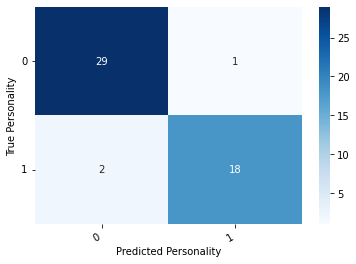

In [18]:
def show_confusion_matrix(confusion_matrix):
        hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
        
        plt.ylabel('True Personality')
        plt.xlabel('Predicted Personality')

cm = confusion_matrix(prediction, actual_label)
show_confusion_matrix(cm)

In [19]:
def tokenize_function(text):
    return tokenizer(text, padding='max_length', max_length=256)

In [20]:
predict_path = os.listdir('processed_clean')

In [36]:
for path in predict_path:
    if path != '.ipynb_checkpoints':
        print("Proses Dataset:", path)
        df = df = pd.read_csv(f"processed_clean/{path}")
        predict_text = df['Text'].apply(tokenize_function)

        prediction = trainer.predict(predict_text)
        prediction = prediction.predictions.argmax(1)

        df['traits'] = prediction
        df['traits'] = df['traits'].map({0:"Neuroticism", 1:"Extraversion"})
        df['prediction'] = prediction 

        df.to_csv(f'dataset_classification/{path}', index=False)

Proses Dataset: @bayu_joo_user_tweets.csv


***** Running Prediction *****
  Num examples = 2503
  Batch size = 8
***** Running Prediction *****
  Num examples = 1637
  Batch size = 8


Proses Dataset: @cursedkidd_user_tweets.csv
Proses Dataset: @iirman__user_tweets.csv


***** Running Prediction *****
  Num examples = 2581
  Batch size = 8
***** Running Prediction *****
  Num examples = 2044
  Batch size = 8


Proses Dataset: @dwikimic_user_tweets.csv


***** Running Prediction *****
  Num examples = 1861
  Batch size = 8


Proses Dataset: @uttazt__user_tweets.csv
Proses Dataset: @ainunrozi_user_tweets.csv


***** Running Prediction *****
  Num examples = 2423
  Batch size = 8


Proses Dataset: @pinotski_user_tweets.csv


***** Running Prediction *****
  Num examples = 2494
  Batch size = 8


Proses Dataset: @hotradero_user_tweets.csv


***** Running Prediction *****
  Num examples = 2741
  Batch size = 8


Proses Dataset: @Nicho_Silalahi_user_tweets.csv


***** Running Prediction *****
  Num examples = 2334
  Batch size = 8


Proses Dataset: @handokotjung_user_tweets.csv


***** Running Prediction *****
  Num examples = 2220
  Batch size = 8
***** Running Prediction *****
  Num examples = 1841
  Batch size = 8


Proses Dataset: @radenrauf_user_tweets.csv


***** Running Prediction *****
  Num examples = 1166
  Batch size = 8


Proses Dataset: @ayubsr_user_tweets.csv
Proses Dataset: @andihidayat_user_tweets.csv


***** Running Prediction *****
  Num examples = 2872
  Batch size = 8
***** Running Prediction *****
  Num examples = 1107
  Batch size = 8


Proses Dataset: @ekowboy2_user_tweets.csv
Proses Dataset: @jek____user_tweets.csv


***** Running Prediction *****
  Num examples = 1686
  Batch size = 8


Proses Dataset: @Mdy_Asmara1701_user_tweets.csv


***** Running Prediction *****
  Num examples = 2600
  Batch size = 8


In [56]:
result_path = os.listdir('dataset_classification')

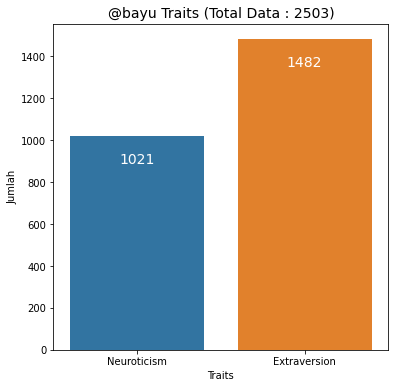

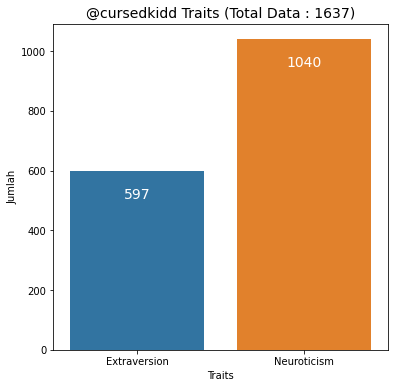

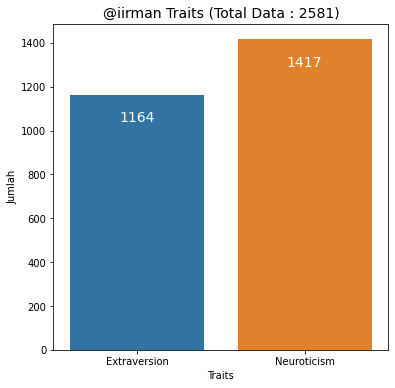

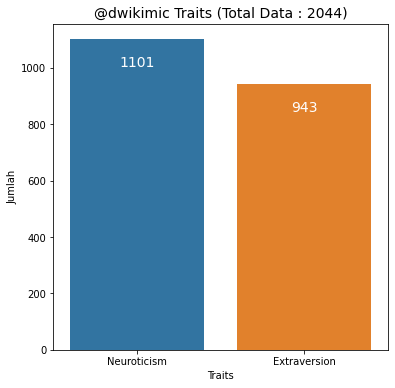

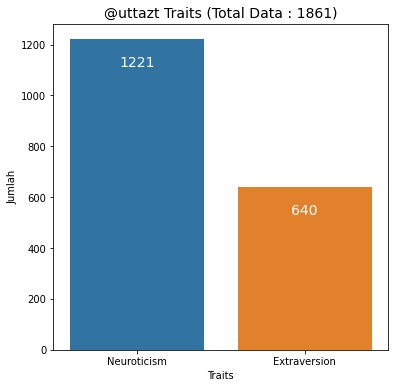

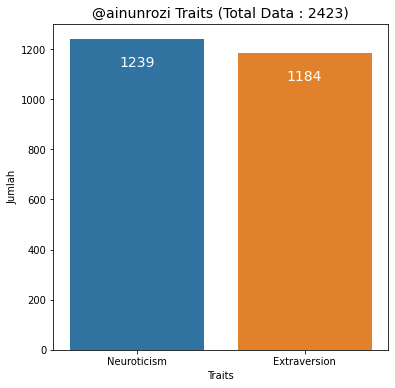

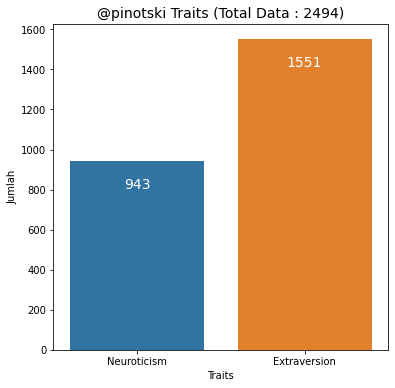

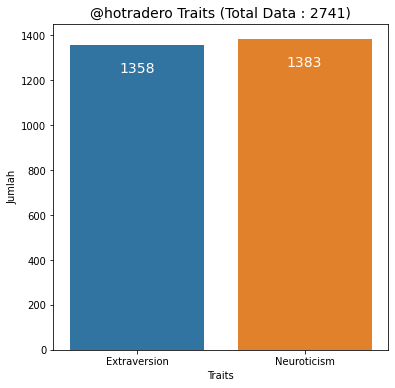

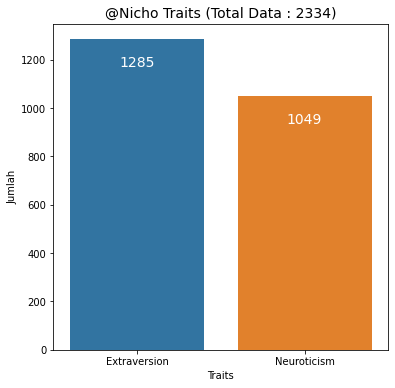

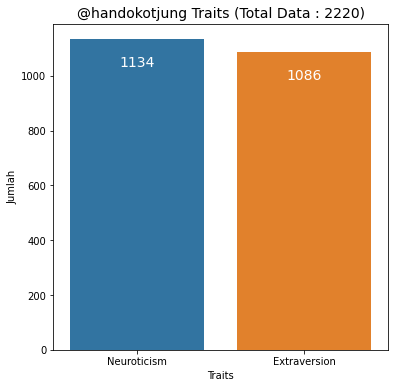

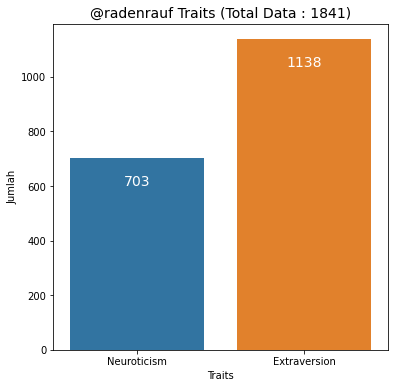

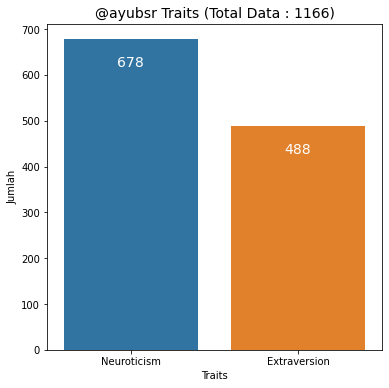

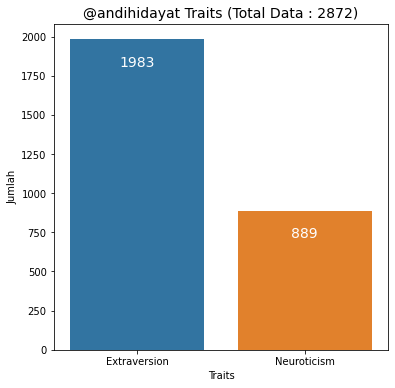

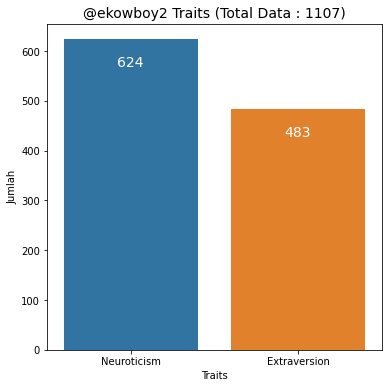

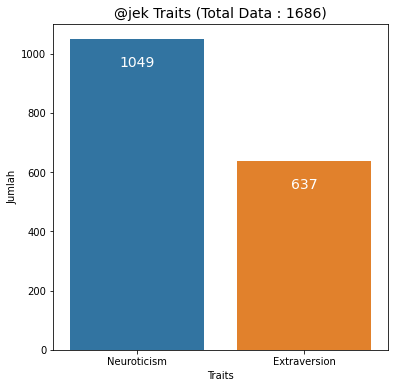

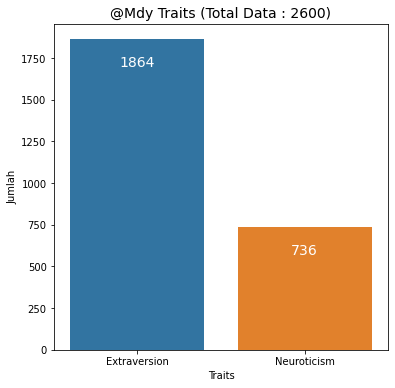

In [60]:
for path in result_path:
    if path != '.ipynb_checkpoints':
        df = pd.read_csv(f"dataset_classification/{path}")
        total = len(df)
        
        plt.figure(figsize=(6, 6))

        ax = sns.countplot(data=df, x = 'traits')

        for p in ax.patches:
            ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=14)

        plt.xlabel("Traits")
        plt.ylabel("Jumlah")
        plt.title(f"{path.split('_')[0]} Traits (Total Data : {total})", fontsize=14)

        plt.show()